<a href="https://colab.research.google.com/github/AlanMarquesRocha/alanmarquesrocha/blob/main/seminario_estudos_especiais_lbp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Programa de Pós-Graduação em Engenharia Elétrica e de Computação (PPGEEC)**
### **Estudos Especiais (BBP1080)**
### **Seminário - Redes Neurais Convolucionais - Uma breve introdução**
### Identificação automática de defeitos em imagens eletroluminescentes de células fotovoltaicas de silício monocristalino
### **Discente: Alan Marques da Rocha**


# **PARTE I: Extração de características de textura aplicando-se a técnica Padrão Binário Local (do inglês, ``LOCAL BINARY PATTERN`` (LBP))**

### **1ª Etapa: Importação das bibliotecas necessárias para a extração de características de texturas baseada em LBP (``Local Binary Pattern``)**

In [3]:
import cv2
from skimage.color import rgb2gray
from PIL import Image

# importação da lib do método LBP
from skimage.feature import local_binary_pattern

### **2ª Etapa: Importação das bibliotecas necessárias para implementação da Rede Neural Convolucional (CNN)**

In [4]:
# Libraries that will import classes, functions and methods from CNN
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# to show the proposed model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tf.__version__

'2.12.0'

### **3ª Etapa: Importação das libs para acesso a pastas do drive, manipulação de dados e plotagem de gráficos**

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Importação de libs para acesso a repositórios
import glob
from skimage import io

# for generation and random values
import random

# lib de validação cruzada com Stratified K-fold
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **4ª Etapa: Copiando as imagens para um diretório de acesso do colab**

In [6]:
# Realiza a cópia de uma pasta específica do drive no ambiente colab:
# O comando abaixo realiza uma cópia das imagens que serão utilizadas no projeto.

# cópia as imagens do dataset para uma pasta específica do drive
!cp -R /content/gdrive/MyDrive/_ppgeec_mestrado/estudos_especiais/dataset/mono dataset/

### **5ª Etapa: Carregando as imagens do ``dataset``**

#### **5.1: Carregando as imagens e convertendo em Níveis de cinza**

In [40]:
# Carregando as labels das imagens do dataset
labels = pd.read_csv('/content/gdrive/MyDrive/_ppgeec_mestrado/estudos_especiais/dataset/labels_binary.csv', sep=';')

In [8]:
# Pega a lista de todas as imagens no diretório [dataset]
paths = glob.glob("/content/dataset/*.png")

imgs_gray = [] # cria uma lista vazia para armazenar as imagens em níveis de cinza.

# importa as imagens, converte para níveis de cinza e armaneza na lista imgs_gray.
for path in paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs_gray.append(gray)


### **Pré-processamento e Extração de Características das Imagens**

In [9]:
import os
import cv2
from skimage.feature import local_binary_pattern

# Define o diretório onde as imagens serão salvas
output_dir = "/content/imagens_lbp"

# Cria o diretório, caso ele não exista
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Pega a lista de todas as imagens no diretório
paths = glob.glob("/content/dataset/*.png")

# Aplica o LBP para cada imagem no diretório
for path in paths:
    # Pega o nome do arquivo sem o caminho do diretório
    filename = os.path.basename(path)
    
    # Lê a imagem e converte para níveis de cinza
    img = cv2.imread(path, 0)

    imgs_filter = cv2.bilateralFilter(img, 30, 15, 15)

    # tipo de LBP
    METHOD = 'uniform'  
    radius = 1  # distância entre o pixel central e a comparação dos pixels
    n_points = 8 * radius  # define o número de comparações dos pixels

    # Aplica o LBP
    lbp = local_binary_pattern(imgs_filter, n_points, radius, METHOD)

    # Normaliza o resultado para que tenha valores no intervalo [0, 255]
    lbp = (lbp / lbp.max()) * 255
    lbp = lbp.astype("uint8")
    
    # Define o caminho onde a imagem em LBP será salva
    output_path = os.path.join(output_dir, filename)
    
    # Salva a imagem em LBP no diretório de saída
    cv2.imwrite(output_path, lbp)


### **Ligação dos atributos (imagens) com suas respectivas classes do dataset**

In [10]:

# Define o caminho para o diretório onde as imagens LBP estão armazenadas
lbp_dir = "/content/imagens_lbp/"

# Cria uma lista para armazenar os atributos LBP de cada imagem
lbp_features = []

# Percorre a lista de imagens no diretório e extrai os atributos LBP
for filename in os.listdir(lbp_dir):
    # Lê a imagem LBP
    lbp = cv2.imread(os.path.join(lbp_dir, filename), cv2.IMREAD_GRAYSCALE)

    # Adiciona os atributos LBP na lista
    lbp_features.append(lbp.flatten())

# Converte a lista de atributos LBP em um array numpy
X = np.array(lbp_features)

# Cria um dicionário para mapear as classes para valores numéricos
class_mapping = {"OK": 0, "Defect": 1}

# Mapeia as classes para valores numéricos
y = labels["prob_defect"].map(class_mapping)

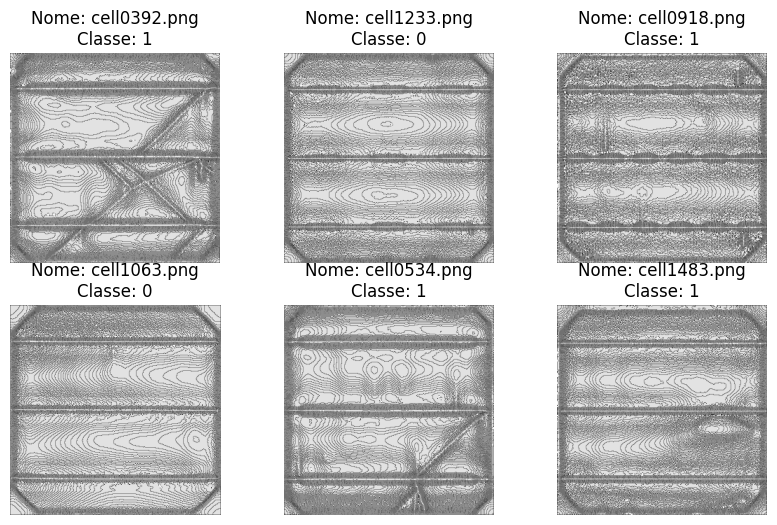

In [13]:
# Define o diretório onde as imagens estão armazenadas
img_dir = "/content/imagens_lbp/"

# Define a quantidade de linhas e colunas da grade de subplots
n_rows = 2
n_cols = 3

# Define o tamanho das imagens que serão plotadas
img_size = (300, 300)

# Cria uma lista com nomes de arquivos aleatórios
filenames = np.random.choice(os.listdir(img_dir), size=n_rows*n_cols, replace=False)

# Cria uma figura e uma grade de subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))

# Percorre a grade de subplots e plota as imagens com seus nomes e classes
for i, ax in enumerate(axes.flat):
    # Pega o nome do arquivo da imagem
    filename = filenames[i]

    # Pega a classe da imagem
    classe = labels.loc[labels['image'] == filename]['prob_defect'].values[0]

    # Carrega a imagem
    img = cv2.imread(os.path.join(img_dir, filename))

    # Redimensiona a imagem
    img = cv2.resize(img, img_size)

    # Plota a imagem com o nome e a classe
    ax.imshow(img)
    ax.set_title(f'Nome: {filename}\nClasse: {classe}')
    ax.axis('off')

plt.show()


#### **5.2 Informações sobre o dataset**

O conjunto de dados possui duas classes, a saber: 

- Funcionais: 0.0
- Defeituosas: 1.0

A divisão do conjunto de dados é apresentado a seguir:

In [14]:
# Apresentando a quantidade de células defeituosas (classe 0.0) e funcionais (classe 1.0)
labels['prob_defect'].value_counts()


0    539
1    535
Name: prob_defect, dtype: int64

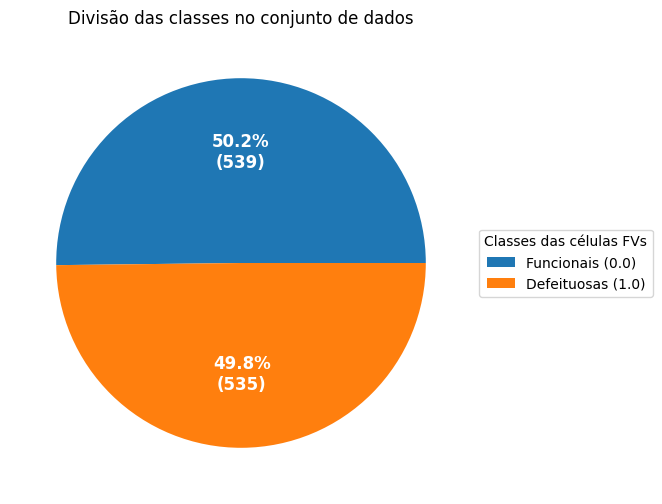

In [10]:
# Area that plots the graph and defines its size
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

# Class information
recipe = ['Funcionais (0.0)', 'Defeituosas (1.0)']

# The amount of data is reported
data_class = [540, 536]

# Shows the percentage of each class in the dataset
def func(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the chart and placing the inner legend function
wedges, texts, autotexts = ax.pie(data_class, autopct = lambda pct: func(pct, data_class),
                                  textprops=dict(color = "w"))

# Defining the external caption box, title, location and where to 'anchor the box'
ax.legend(wedges, recipe,
          title="Classes das células FVs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Here we set the text size from within the graphic, and the font weight to bold
plt.setp(autotexts, size=12, weight="bold")

# chart title
ax.set_title("Divisão das classes no conjunto de dados")

# showing the chart
plt.show()

#### **5.3: Mostrando alguns exemplos de imagens**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino em níveis de cinza.

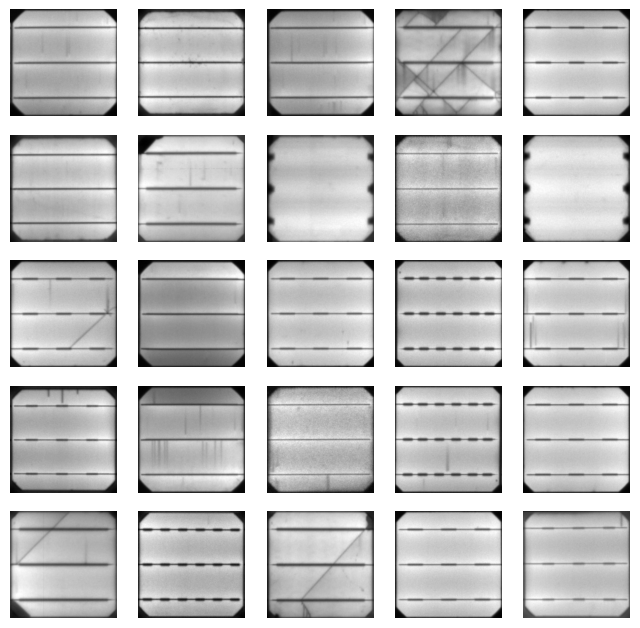

In [8]:
L_grid = 5 # Especifica o número de linhas
W_grid = 5 # Especifica o número de colunas

k = 0.2
fig, axes = plt.subplots(L_grid, W_grid, figsize = (8,8))
axes = axes.ravel()
n_images = len(imgs_gray)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_gray[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

### **6ª Etapa: Pré-Processamento das Imagens**


#### **6.1 Fitragem das imagens do dataset**

Nessa etapa será realizado a aplicação do **``Filtro Gaussiano Bilateral``** através de uma função da biblioteca OpenCV.

Um filtro bilateral é um filtro de preservação de borda e redução de ruído. Ele calcula a média de pixels com base em sua proximidade espacial e similaridade radiométrica. [Fonte](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html)

Os principais atributos da função ``cv2.bilateralFilter( )`` são apresentadas a seguir:

``cv2.bilateralFilter``	(<br>
``InputArray``: Fonte de imagem de 8 bits ou ponto flutuante, 1 canal ou 3 canais. <br>
d: Diâmetro de cada vizinhança de pixel que é usado durante a filtragem <br> 
)		

In [9]:
# Cria uma lista para guardar as imagens filtradas
imgs_filter = []

# Realiza o processo de filtragem papra cada imagem dentro da lista imgs_gray
for img in imgs_gray:
  # aplicando o filtro bilateral com uma distancia d = 30
  imgs_filter.append(cv2.bilateralFilter(img, 30, 15, 15))

#### **6.2 Mostrando alguns exemplos do resultado obtido**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino com aplicação do filtro Gaussiano bilateral

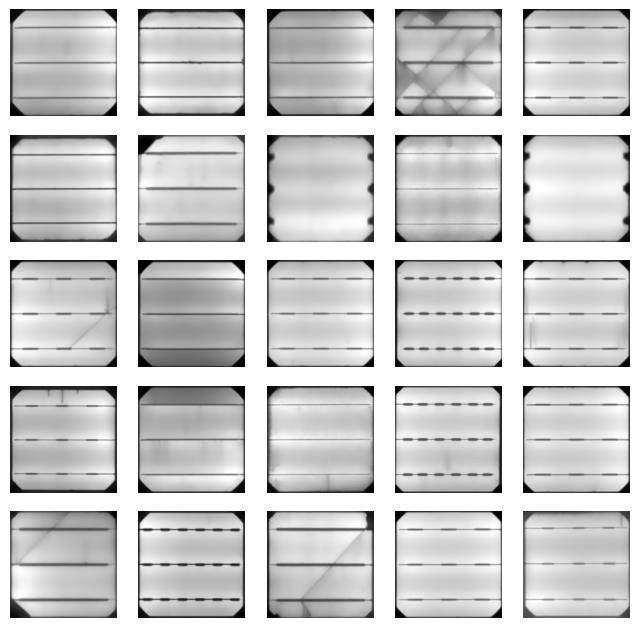

In [10]:
L_grid = 5 # Especifica o número de linhas
W_grid = 5 # Especifica o número de colunas

fig, axes = plt.subplots(L_grid, W_grid, figsize = (8,8))
axes = axes.ravel()
n_images = len(imgs_filter)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_filter[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

### **7ª Etapa: Aplicação do Método ``Local Binary Pattern (LBP)`` para extração de características de textura.**

In [11]:
# tipo de LBP
METHOD = 'uniform'  
radius = 1  # distância entre o pixel central e a comparação dos pixels
n_points = 8 * radius  # define o número de comparações dos pixels

# cria uma lista para armazenar as características de textura das imagens
imgs_lbp = []

# Cria o LBP para cada imagem filtrada na etapa 6.1 que encontra-se armazenada na lista imgs_filter = []
for img in imgs_filter:
  imgs_lbp.append(local_binary_pattern(img, n_points, radius, METHOD))

#### **7.1: Mostrando alguns exemplos do resultado obtido**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino com aplicação do LBP.

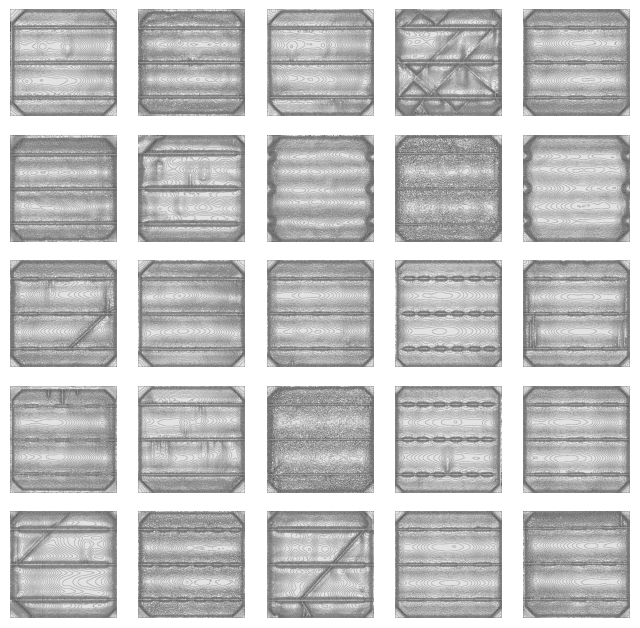

In [12]:
L_grid = 5 # Especifica o número de linhas
W_grid = 5 # Especifica o número de colunas

fig, axes = plt.subplots(L_grid, W_grid, figsize = (8,8))
axes = axes.ravel()
n_images = len(imgs_lbp)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_lbp[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

# **PARTE II: Implementação da ``Rede Neural Convolucional`` (CNN) para classificação de defeitos em células de módulos FVs de silício monocristalino**

### **8ª Etapa: Normalização dos dados e Validação Cruzada com ``Stratified K-fold``**

#### **8.1: Importação do conjunto de treino e teste**

A seguir serão importados os conjuntos de treino e validação após a extração de atributos por meio do LBP.

In [30]:
paths = glob.glob('/content/imagens_lbp/*.png')

paths = sorted(paths)

# verifica se o número de imagens é igual ao número de labels
#assert len(imgs_lbp) == len(labels_list)

imgs_gray = [] # cria uma lista vazia para armazenar as imagens em níveis de cinza.

# importa as imagens, converte para níveis de cinza e armaneza na lista imgs_gray.
for path in paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs_gray.append(gray)

In [41]:
# extrai as labels do dataframe
labels_list = list(labels['prob_defect'])

# cria uma lista para armazenar as imagens normalizadas
imgs_normalized = []

# normaliza cada imagem em imgs_lbp e adiciona na lista imgs_normalized
for img in imgs_gray:
  img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))
  imgs_normalized.append(img_norm)

In [42]:
# apresenta a matriz que representa uma imagem normalizada:

imgs_normalized[10]

array([[0.33333333, 0.55294118, 0.55294118, ..., 0.55294118, 0.55294118,
        0.33333333],
       [0.55294118, 0.88627451, 0.88627451, ..., 0.88627451, 0.88627451,
        0.55294118],
       [0.55294118, 0.88627451, 0.88627451, ..., 0.88627451, 0.88627451,
        0.55294118],
       ...,
       [0.55294118, 0.88627451, 0.88627451, ..., 0.33333333, 0.88627451,
        0.55294118],
       [0.55294118, 0.88627451, 0.88627451, ..., 0.88627451, 0.88627451,
        0.55294118],
       [0.33333333, 0.55294118, 0.55294118, ..., 0.55294118, 0.55294118,
        0.33333333]])

### **9ª Etapa: Construção do modelo proposto da CNN**

O modelo ``Sequential()`` disponibiliza ferramentas de inferência e treinamento para CNNs

As camadas de ``convolução`` e ``pooling`` são adicionadas usado o método ``add``

Quatro métodos foram utilizados para a construção da CNN, a saber: ``layers.Conv2D``, ``layers.MaxPooling2D``, ``layers.Flatten`` and ``layers.Dense``. 

Os principais atributos de cada método são apresentados a seguir:

#### **9.1 Características dos métodos utilizados**

**``tf.keras.layers.Conv2D``**(<br>
    ``filters``: Determines the number of output filters in the convolution).<br>
    ``kernel_size``: Specifies the height and width of the 2D convolution window; <br>
    ``strides``: Specifies the convolution steps along the height and width;<br>
    ``padding``: Complements the filling of the image, in case the stride exceeds the dimensions;<br>
    ``activation``: Activation function to use. <br>

Types of activation functions can be checked [here.](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

---

**``tf.keras.layers.MaxPool2D``**(<br>
    ``pool_size``: Size of the analysis window for pixels, returning the maximum value;<br>
    ``strides``: Step values. Specifies how far the nesting window moves for each nesting step;<br>
    ``padding``: Complements the padding of the image, in case the stride exceeds the dimensions. <br>

---

**``tf.keras.layers.Flatten( )``**: Does not receive any parameter. It is responsible for converting the feature matrix of the last layer of CNN to a vector that will be applied in the input layer of the classifier.

---

**``tf.keras.layers.Dense``**(<br>
    ``units``: Positive integer, output space dimensionality.<br>
    ``activation``: Activation function to be used (Ex: ``softmax``)

  ---

### **9.2 Implementação do modelo da CNN**

- 2 x CONV2D
- 2 x MaxPooling2D 
- 1 x Flatten
- 3 x Dense

In [96]:
# number of filters for each convolution layer (filters)
c_entrada = [100, 64]

# number of neurons in fully connected layers:
c_dense = [240, 120, 2]

# defining the kernel:
kernel = (1, 1)

# convolution steps (stride)
strd = 1

# defining the activation function of the convolution layers:
act_func = 'relu'

# setting the cnn classifier activation function
act_func_class = 'softmax'

# starting the model
model_cnn = models.Sequential()


# 1st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[0], kernel, strd, activation = act_func, input_shape=(300, 300, 1)))
# 1st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# 2st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[1], kernel, strd, activation = act_func))
# 2st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# Conversion of attribute matrix to attribute vector
model_cnn.add(layers.Flatten())


# 1st layer fully connected:
model_cnn.add(layers.Dense(c_dense[0], activation = act_func))
# 2st layer fully connected:
model_cnn.add(layers.Dense(c_dense[1], activation = act_func))

# Last layer of classifier with softmax activation function.
model_cnn.add(layers.Dense(c_dense[2], activation = act_func_class))

In [98]:
# Apresenta o sumário das camadas da CNN
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 300, 300, 100)     200       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 150, 150, 100)    0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 150, 150, 64)      6464      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 360000)            0         
                                                                 
 dense_35 (Dense)            (None, 240)             

### **não executar essa célula**

In [ ]:
# NÃO EXECUTAR ESSA CÉLULA

# MELHOR TOPOLOGIA DE REDE EM TERMOS DE ACURÁCIA

# number of filters for each convolution layer (filters)
c_entrada = [120, 64]

# number of neurons in fully connected layers:
c_dense = [240, 120, 2]

# defining the kernel:
kernel = (1, 1)

# convolution steps (stride)
strd = 1

# defining the activation function of the convolution layers:
act_func = 'relu'

# setting the cnn classifier activation function
act_func_class = 'softmax'

# starting the model
model_cnn = models.Sequential()


# 1st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[0], kernel, strd, activation = act_func, input_shape=(300, 300, 1)))
# 1st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# 2st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[1], kernel, strd, activation = act_func))
# 2st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# Conversion of attribute matrix to attribute vector
model_cnn.add(layers.Flatten())


# 1st layer fully connected:
model_cnn.add(layers.Dense(c_dense[0], activation = act_func))
# 2st layer fully connected:
model_cnn.add(layers.Dense(c_dense[1], activation = act_func))

# Last layer of classifier with softmax activation function.
model_cnn.add(layers.Dense(c_dense[2], activation = act_func_class))

### **9.4 - Divisão dos dados em treinamento e teste**

In [97]:
# Dividindo os dados em treinamento, teste e validação.
x_train, x_test, y_train, y_test = train_test_split(imgs_normalized, labels['prob_defect'], test_size=0.2, stratify=labels['prob_defect'])

# Dividindo os dados de treinamento em treinamento e validação com amostragem estratificada
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

print('Número de amostras em x_train:', len(x_train))
print('Número de amostras em y_train:', len(y_train))
print('Número de amostras em x_test:', len(x_test))
print('Número de amostras em y_test:', len(y_test))
print('Número de amostras em x_val:', len(x_val))
print('Número de amostras em y_val:', len(y_val))

Número de amostras em x_train: 644
Número de amostras em y_train: 644
Número de amostras em x_test: 215
Número de amostras em y_test: 215
Número de amostras em x_val: 215
Número de amostras em y_val: 215


### **9.5 Etapa de validação do modelo**

In [99]:
# definindo o tipo de otimizador e métrica para verificar a assertividade do modelo.
model_cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam',
            metrics = ['accuracy'])
     

In [109]:
# definir o número de épocas e tamanho do batch de treinamento
epochs = 60
batch_size = 30

# treinar o modelo
history = model_cnn.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_data=(x_val, y_val))

Epoch 1/60
22/22 [==============================] - 4s 163ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.6894 - val_accuracy: 0.8186
Epoch 2/60
22/22 [==============================] - 3s 155ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.8047
Epoch 3/60
22/22 [==============================] - 3s 155ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6998 - val_accuracy: 0.8233
Epoch 4/60
22/22 [==============================] - 3s 140ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7425 - val_accuracy: 0.7953
Epoch 5/60
22/22 [==============================] - 3s 140ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7787 - val_accuracy: 0.7953
Epoch 6/60
22/22 [==============================] - 3s 142ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7089 - val_accuracy: 0.8233
Epoch 7/60
22/22 [==============================] - 3s 144ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7278 - val_accuracy: 0.8140
Epoch 

In [110]:
# Apresenta a acurácia do conjunto de validação do modelo proposto
test_loss, evaluation = model_cnn.evaluate(x_test, y_test, verbose = 2);

print('\nAcurácia do teste atual: ', evaluation);

7/7 - 0s - loss: 0.9112 - accuracy: 0.7349 - 396ms/epoch - 57ms/step

Acurácia do teste atual:  0.734883725643158


In [111]:
# Apresenta a acurácia do conjunto de validação do modelo proposto
test_loss, evaluation = model_cnn.evaluate(x_val, y_val, verbose = 2);


print('\nAcurácia na validação do modelo: ', evaluation);

7/7 - 0s - loss: 0.8887 - accuracy: 0.8140 - 397ms/epoch - 57ms/step

Acurácia na validação do modelo:  0.8139534592628479


### **11ª Etapa: Apresentação da Matriz de Confusão (MC) das classificações preditas.**

7/7 [==============================] - 0s 52ms/step


<Axes: >

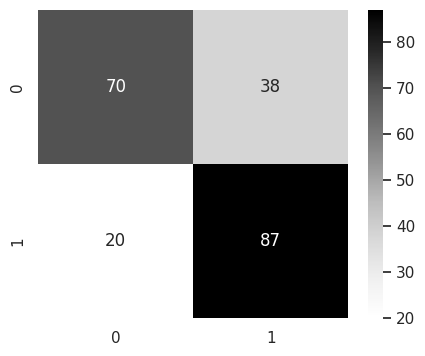

In [105]:
predict_x = model_cnn.predict(x_test) 
predicted_classes = np.argmax(predict_x, axis = 1)

cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (5,4))
sns.heatmap(cm, annot=True, cmap="Greys")

In [106]:
cm

array([[70, 38],
       [20, 87]])

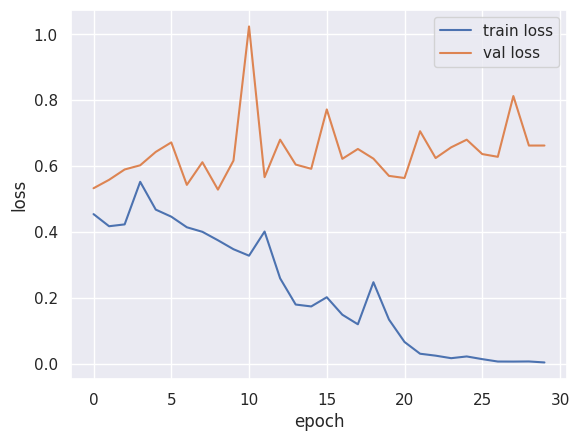

In [107]:
import matplotlib.pyplot as plt

# Extrai a perda de treinamento e de validação do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plota o gráfico da perda em função do treinamento
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


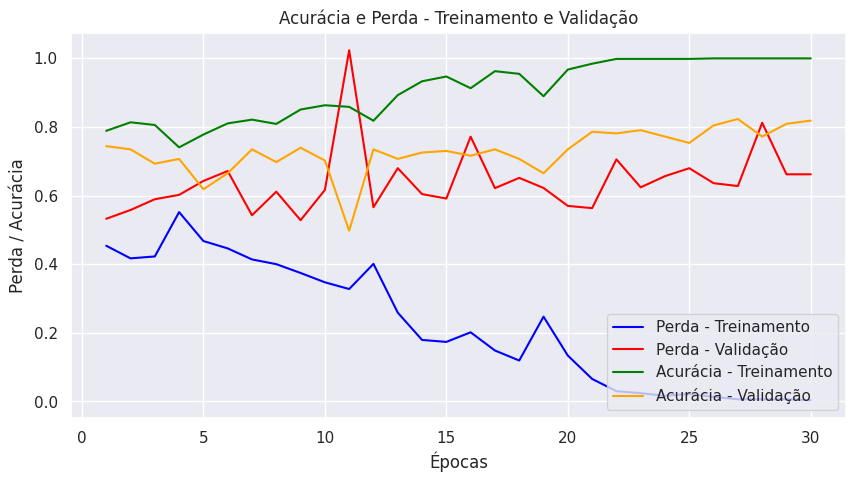

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# extrair os valores de perda e acurácia do histórico
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# definir a quantidade de épocas
epochs = range(1, len(loss) + 1)

# plotar os gráficos
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epochs, loss, label='Perda - Treinamento', color='blue')
ax.plot(epochs, val_loss, label='Perda - Validação', color='red')
ax.plot(epochs, acc, label='Acurácia - Treinamento', color='green')
ax.plot(epochs, val_acc, label='Acurácia - Validação', color='orange')

ax.set_xlabel('Épocas')
ax.set_ylabel('Perda / Acurácia')
ax.set_title('Acurácia e Perda - Treinamento e Validação')
ax.legend(loc='lower right')

plt.show()
